### Predicting Length of Patient stay in hospitals


Task: Predict the Length of stay for each patient on case by case basis so that Hospitals can use this information
 for optimal resource allocation and better functioning.
 
 Motivation: During the pandemic, There has been an unpresidented demand for hospital beds to treat Covid-19 patients.
 This has make it more important to be able to discharge patients and demmand for new techniques for forecasting patient stay in the hospitals. The dataset used below is from a kaggle competition and we will investigate if it is possible to help predict patient stay duration.


In [1]:
# Loading packages
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np 
import seaborn as sns 
import math 
import matplotlib.pyplot as plt
import sklearn as svm
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder

## ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier 
#from sklearn.ensemble import DecisionTree

# Pre-processing algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


%matplotlib inline
#pd.set_option('display.max_columns', None)
#sns.set_theme(style="ticks", color_codes=True)


In [2]:
# Load Dataset
df = pd.read_csv('healthcare/train_data.csv')
test_data = pd.read_csv('healthcare/test_data.csv')
# carry out test to ensure that the split is even


In [3]:
# EDA 
print(df.head(2))
df.columns
# rename column names
df.columns = [x.lower().replace(' ','_') for x in df.columns]




   case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0        1              8                  c                   3   
1        2              2                  c                   5   

  Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                    Z                                  3  radiotherapy   
1                    Z                                  2  radiotherapy   

  Ward_Type Ward_Facility_Code  Bed Grade  patientid  City_Code_Patient  \
0         R                  F        2.0      31397                7.0   
1         S                  F        2.0      31397                7.0   

  Type of Admission Severity of Illness  Visitors with Patient    Age  \
0         Emergency             Extreme                      2  51-60   
1            Trauma             Extreme                      2  51-60   

   Admission_Deposit   Stay  
0             4911.0   0-10  
1             5954.0  41-50  


In [4]:
print(df.department.unique())

['radiotherapy' 'anesthesia' 'gynecology' 'TB & Chest disease' 'surgery']


### Missing data
By checking our missing data, we can see that `1.432%`  of the `city_code_patient` data is missing from the column and `0.0355%` of the `bed_grade` is missing. 
Since this codes are categorical, we decide its safer to  drop the columns from our dataset.


In [5]:

print(round(((df.isnull().sum())/df.shape[0] *100),4))
#print(df.city_code_patient.isnull().fillna(mean()))
#from sklearn.impute import SimpleImputer
#my_imputer = SimpleImputer()
print(df.city_code_patient.unique())

cols_with_missing = [col for col in df.columns
                     if df[col].isnull().any()]

# Drop columns in training and validation data
df = df.drop(cols_with_missing, axis=1)


case_id                              0.0000
hospital_code                        0.0000
hospital_type_code                   0.0000
city_code_hospital                   0.0000
hospital_region_code                 0.0000
available_extra_rooms_in_hospital    0.0000
department                           0.0000
ward_type                            0.0000
ward_facility_code                   0.0000
bed_grade                            0.0355
patientid                            0.0000
city_code_patient                    1.4232
type_of_admission                    0.0000
severity_of_illness                  0.0000
visitors_with_patient                0.0000
age                                  0.0000
admission_deposit                    0.0000
stay                                 0.0000
dtype: float64
[ 7.  8.  2.  5.  6.  3.  4.  1.  9. 14. nan 25. 15. 12. 10. 28. 24. 23.
 20. 11. 13. 21. 18. 16. 26. 27. 22. 19. 31. 34. 32. 30. 29. 37. 33. 35.
 36. 38.]


### Encoding

In [6]:

#Encoding numerical columns
# Here we can improve the features futher by converting admission_deposit into a categorical vaiable by placing data into bins
print(df.admission_deposit.describe())
df.admission_deposit.value_counts(bins=5)


custom_bucket_array = list(range(1500,12000,500))
#print(custom_bucket_array)
#df['admission_deposit_mod']= pd.cut(df['admissison_deposit'],np.array(custom_bucket_array) )
#print(df.admission_deposit.value_counts())

df['admission_deposit_mapped']=pd.cut(df['admission_deposit'],np.array(custom_bucket_array) )
df.admission_deposit_mapped.value_counts()

count    318438.000000
mean       4880.749392
std        1086.776254
min        1800.000000
25%        4186.000000
50%        4741.000000
75%        5409.000000
max       11008.000000
Name: admission_deposit, dtype: float64


(4500, 5000]      71973
(4000, 4500]      64905
(5000, 5500]      51118
(3500, 4000]      36926
(5500, 6000]      30108
(6000, 6500]      17117
(3000, 3500]      14951
(6500, 7000]      10081
(7000, 7500]       5960
(2500, 3000]       5102
(7500, 8000]       3766
(8000, 8500]       2385
(8500, 9000]       1413
(2000, 2500]       1306
(9000, 9500]        649
(9500, 10000]       327
(1500, 2000]        173
(10000, 10500]      125
(10500, 11000]       49
(11000, 11500]        4
Name: admission_deposit_mapped, dtype: int64

In [7]:
# # columns that are object types
s = (df.dtypes == 'object')
obj_columns = list(s[s].index)

print(obj_columns)
# The following columns are all categorical variables which need to be tranformed
# obj_columns = ['hospital_type_code', 'hospital_region_code', 'department', 'ward_type',
#'ward_facility_code', 'type_of_admission', 'severity_of_illness', 'age', 'stay']

['hospital_type_code', 'hospital_region_code', 'department', 'ward_type', 'ward_facility_code', 'type_of_admission', 'severity_of_illness', 'age', 'stay']


In [8]:
# Encoding categorical variables
encoder = LabelEncoder()

for i in range(len(obj_columns)):

    df1_encoded= encoder.fit_transform(df[obj_columns[i]])
    name = str(obj_columns[i] + '_mapped')
    df[name] = df1_encoded

In [9]:
print(df.head(3))

   case_id  hospital_code hospital_type_code  city_code_hospital  \
0        1              8                  c                   3   
1        2              2                  c                   5   
2        3             10                  e                   1   

  hospital_region_code  available_extra_rooms_in_hospital    department  \
0                    Z                                  3  radiotherapy   
1                    Z                                  2  radiotherapy   
2                    X                                  2    anesthesia   

  ward_type ward_facility_code  patientid  ... admission_deposit_mapped  \
0         R                  F      31397  ...             (4500, 5000]   
1         S                  F      31397  ...             (5500, 6000]   
2         S                  E      31397  ...             (4500, 5000]   

  hospital_type_code_mapped  hospital_region_code_mapped department_mapped  \
0                         2                    

In [10]:
# number of unique values in each row
#print(df.nunique())

# Get number of unique entries in each column with categorical data
obj_nunique = list(map(lambda col: df[col].nunique(), obj_columns))
d = dict(zip(obj_columns, obj_nunique))

# Print number of unique entries by column, in ascending order
print(sorted(d.items(), key=lambda x: x[1]))


[('hospital_region_code', 3), ('type_of_admission', 3), ('severity_of_illness', 3), ('department', 5), ('ward_type', 6), ('ward_facility_code', 6), ('hospital_type_code', 7), ('age', 10), ('stay', 11)]


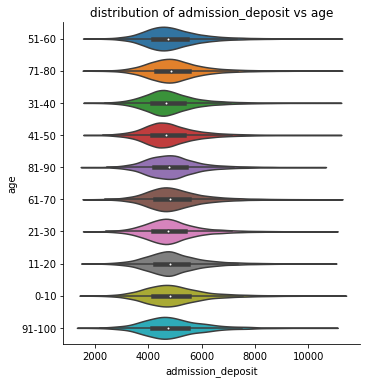

In [11]:
sns.catplot(x="admission_deposit", y="age",kind="violin",data=df)
plt.title('distribution of admission_deposit vs age')
plt.show()

We will use correlation to find possible features that we can use to describe the corrrelation in our Data.

In [14]:

correlations = df.corr()

print(correlations.stay_mapped.sort_values(ascending=False))
print(correlations.stay_mapped[(correlations.stay_mapped > 0.05) ])

stay_mapped                          1.000000
visitors_with_patient                0.537537
ward_type_mapped                     0.185191
age_mapped                           0.094163
hospital_type_code_mapped            0.058592
hospital_code                        0.042846
department_mapped                    0.033287
type_of_admission_mapped             0.023617
hospital_region_code_mapped          0.011905
city_code_hospital                   0.006381
patientid                            0.001125
ward_facility_code_mapped           -0.004552
severity_of_illness_mapped          -0.031188
admission_deposit                   -0.052077
case_id                             -0.053882
available_extra_rooms_in_hospital   -0.121120
Name: stay_mapped, dtype: float64
visitors_with_patient        0.537537
hospital_type_code_mapped    0.058592
ward_type_mapped             0.185191
age_mapped                   0.094163
stay_mapped                  1.000000
Name: stay_mapped, dtype: float64


In [15]:
df.columns.unique


<bound method Index.unique of Index(['case_id', 'hospital_code', 'hospital_type_code', 'city_code_hospital',
       'hospital_region_code', 'available_extra_rooms_in_hospital',
       'department', 'ward_type', 'ward_facility_code', 'patientid',
       'type_of_admission', 'severity_of_illness', 'visitors_with_patient',
       'age', 'admission_deposit', 'stay', 'admission_deposit_mapped',
       'hospital_type_code_mapped', 'hospital_region_code_mapped',
       'department_mapped', 'ward_type_mapped', 'ward_facility_code_mapped',
       'type_of_admission_mapped', 'severity_of_illness_mapped', 'age_mapped',
       'stay_mapped'],
      dtype='object')>

Suprisingly `admission_deposit` has a very low correlation with expected length of stay


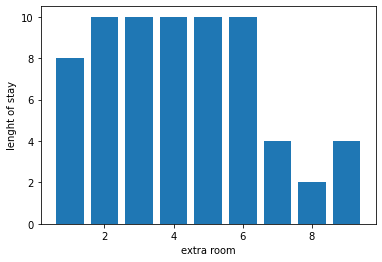

In [16]:
plt.bar(df.available_extra_rooms_in_hospital.head(500), df.stay_mapped.head(500))
plt.xlabel('extra room');plt.ylabel('lenght of stay')
plt.show()

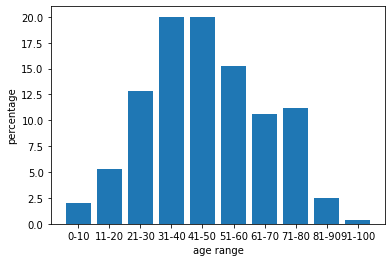

In [17]:
# quick glance to see that 
A= df.age.value_counts(normalize=True).sort_index()
A
plt.bar(A.index, A.values*100)
plt.xlabel('age range')
plt.ylabel('percentage')

plt.show()

Taking a quick glance,we can see a high correlation of 0.53 between `visitors_of_patient` and the `length of stay`.


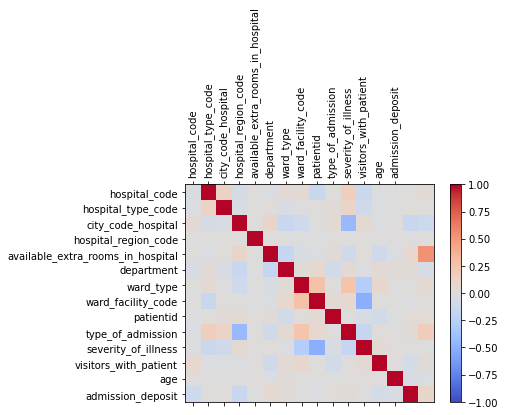

In [29]:

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations[1:15],cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns[1:15]),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns[1:15])
ax.set_yticklabels(df.columns[1:15])
plt.show()




Features selected for Machine Learning Training.

In [30]:
features = ['visitors_with_patient', 'ward_type_mapped', 'age_mapped', 'hospital_type_code_mapped', 'available_extra_rooms_in_hospital','case_id', 'admission_deposit_mapped']

In [31]:
labels = ['stay_mapped']

In [32]:
#Training
X = np.array(df[features])
print(X)
y = np.array(df[labels])
print(y)


[[2 2 5 ... 3 1 Interval(4500, 5000, closed='right')]
 [2 3 5 ... 2 2 Interval(5500, 6000, closed='right')]
 [2 3 5 ... 2 3 Interval(4500, 5000, closed='right')]
 ...
 [3 2 7 ... 3 318436 Interval(4000, 4500, closed='right')]
 [5 1 1 ... 3 318437 Interval(3500, 4000, closed='right')]
 [2 1 1 ... 5 318438 Interval(4500, 5000, closed='right')]]
[[0]
 [4]
 [3]
 ...
 [1]
 [1]
 [0]]


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from time import time

Split our data and begin to create our training pipeline which will use gridsearch and save our trained model to a dictionary.

In [35]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

pipe_lr = Pipeline([('scl', StandardScaler()),
    ('clf', LogisticRegression(random_state=0))])



In [36]:

# Grid search
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
    'clf__C': param_range_fl,
    'clf__solver': ['liblinear']}] 

gs_lr = GridSearchCV(estimator=pipe_lr,
    param_grid=grid_params_lr,
    scoring='accuracy',
    cv=2)
grids = [gs_lr]

grid_dict = {0: 'Logistic Regression'}


In [ ]:
start =time()
# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])	
    # Fit grid search	
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % metrics.accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if metrics.accuracy_score(y_test, y_pred) > best_acc:
        best_acc = metrics.accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
    end = time()
    print("Trained {} in {:.1f} seconds".format(grid_dict[idx], (end - start)*10))



print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

We save our model in `pickle` format in order to be able to use it later on and NOT have to train again!! 

In [41]:
# Save best grid search pipeline to file
# dump_file = 'best_gs_pipeline.pkl'
# joblib.dump(best_gs, dump_file, compress=1)
# print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))



After  our first initial training, we can see that:
- randomforest classifier =  training score of 0.30,
- linear with score of 0.26 
- logistic with score of 0.25





## Conclusion

As we have seen from our results, we are able to predict with an accuracy of `30%` which is good but there is alot of room for improvement.

More Feature engineering can be done:
Using 
